In [1]:
import skimage.io as io
from skimage.color import rgb2gray
import os
import numpy as np
import pandas as pd
from imp import reload
import sys
sys.path.append('../')
import helpers.image_processing as im
import helpers.histogram_classifier as hc

In [68]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

##### Histogram classifier

- Get the data
- Split into test vs. train 75% : 25%
- Train the model = create histogram for each class
- Test the model by predicting on the test data

Get the image classes and names:

In [2]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [6]:
def run_histogram_classifier(class_list, image_names, hist_type):
    """
    Initializes and runs histogram classifier model, and then tests the classification accuracy
    :params class_list: list of relevant image classes
    :params image_names: dictionary of image names for each class
    :params hist_type: name of method for calculating histogram; choices are: (greyscale_histogram, 
        color_histogram, complete_histogram)
    :return: prints out classification accuracy
    """    
    # Split into test and training data
    train, test = hc.split_data(image_names, 0.75)
    
    # Create the model
    model = {}
    for c in class_list:
        mean_image = im.mean_image(train[c], (512, 512, 3), os.path.join('../data/food-101/top_classes/', c, ''))
        if hist_type == 'Greyscale':
            mean_hist, mean_bins = hc.greyscale_histogram(mean_image)
        elif hist_type == 'RGB':
            mean_hist = hc.color_histogram(mean_image)
        elif hist_type == 'Complete':
            mean_hist = hc.complete_histogram(mean_image)
        model[c] = mean_hist
    
    # Evaluate the model
    for metric in ["intersection", "l1_norm", "euclid"]:
        actual_classes = []
        predicted_classes = []
        for c in class_list:
            for i in test[c]:
                img = io.imread(os.path.join('../data/food-101/top_classes/', c, '', i))
                if hist_type == 'Greyscale':
                    img_hist, img_bins = hc.greyscale_histogram(img)
                elif hist_type == 'RGB':
                    img_hist = hc.color_histogram(img)
                elif hist_type == 'Complete':
                    img_hist = hc.complete_histogram(img)

                prediction = hc.classify(img_hist, model, metric)
                actual_classes.append(c)
                predicted_classes.append(prediction)

        actual = np.array(actual_classes)
        predicted = np.array(predicted_classes)
        classification_rate = sum(actual == predicted) / len(predicted)

        print("Using {} histogram and {} metric, classification rate is {:.2f}%".format(hist_type, metric, classification_rate*100))

In [11]:
def run_histogram_classifier_intersection(class_list, image_names, hist_type):
    """
    Initializes and runs histogram classifier model, and then tests the classification accuracy
    :params class_list: list of relevant image classes
    :params image_names: dictionary of image names for each class
    :params hist_type: name of method for calculating histogram; choices are: (greyscale_histogram, 
        color_histogram, complete_histogram)
    :return: actual: array of actual labels
    :return: predicted: array of predicted labels
    """    
    # Split into test and training data
    train, test = hc.split_data(image_names, 0.75)
    
    # Create the model
    model = {}
    for c in class_list:
        mean_image = im.mean_image(train[c], (512, 512, 3), os.path.join('../data/food-101/top_classes/', c, ''))
        if hist_type == 'Greyscale':
            mean_hist, mean_bins = hc.greyscale_histogram(mean_image)
        elif hist_type == 'RGB':
            mean_hist = hc.color_histogram(mean_image)
        elif hist_type == 'Complete':
            mean_hist = hc.complete_histogram(mean_image)
        model[c] = mean_hist
    
    # Evaluate the model
    actual_classes = []
    predicted_classes = []
    for c in class_list:
        for i in test[c]:
            img = io.imread(os.path.join('../data/food-101/top_classes/', c, '', i))
            if hist_type == 'Greyscale':
                img_hist, img_bins = hc.greyscale_histogram(img)
            elif hist_type == 'RGB':
                img_hist = hc.color_histogram(img)
            elif hist_type == 'Complete':
                img_hist = hc.complete_histogram(img)

            prediction = hc.classify(img_hist, model, "intersection")
            actual_classes.append(c)
            predicted_classes.append(prediction)

    actual = np.array(actual_classes)
    predicted = np.array(predicted_classes)
    
    return actual, predicted

***Version 1 - Greyscale***

In [24]:
run_histogram_classifier(class_list, image_names, 'Greyscale')

Using Greyscale histogram and intersection metric, classification rate is 10.27%
Using Greyscale histogram and l1_norm metric, classification rate is 10.27%
Using Greyscale histogram and euclid metric, classification rate is 9.37%


***Version 2 - RGB***

In [25]:
run_histogram_classifier(class_list, image_names, 'RGB')

Using RGB histogram and intersection metric, classification rate is 10.50%
Using RGB histogram and l1_norm metric, classification rate is 10.50%
Using RGB histogram and euclid metric, classification rate is 9.93%


***Version 3 - RGB + Greyscale***

In [26]:
run_histogram_classifier(class_list, image_names, 'Complete')

Using Complete histogram and intersection metric, classification rate is 9.90%
Using Complete histogram and l1_norm metric, classification rate is 9.90%
Using Complete histogram and euclid metric, classification rate is 9.13%


### With complete Metrics:

***Version 1 - Greyscale***

In [13]:
actual, predicted = run_histogram_classifier_intersection(class_list, image_names, 'Greyscale')

In [14]:
accuracy, metrics, confusion = hc.get_metrics(actual, predicted, class_list)

In [15]:
print("Classifier accuracy is: {:.1f}%".format(accuracy*100))

Classifier accuracy is: 9.5%


###### Overall Results:

In [16]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.11,0.71,0.19,250.0
lasagna,0.20,0.00,0.01,250.0
french_toast,0.07,0.01,0.01,250.0
guacamole,0.10,0.24,0.14,250.0
apple_pie,0.11,0.01,0.01,250.0
cheesecake,0.14,0.01,0.02,250.0
hamburger,0.07,0.00,0.01,250.0
fried_rice,0.00,0.00,0.00,250.0
carrot_cake,0.08,0.00,0.01,250.0
chocolate_cake,0.04,0.03,0.03,250.0


###### Confusion Matrix:

In [17]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,177,0,0,21,1,0,0,0,1,3,47,0
lasagna,110,1,7,58,2,0,1,0,2,22,47,0
french_toast,128,0,2,51,1,2,0,0,0,11,54,1
guacamole,142,1,3,60,1,5,0,0,1,22,15,0
apple_pie,108,2,5,66,2,0,2,1,0,25,36,3
cheesecake,114,1,2,31,6,2,4,1,1,18,67,3
hamburger,148,0,0,61,0,0,1,1,0,16,23,0
fried_rice,88,0,2,90,2,3,2,0,3,29,21,10
carrot_cake,128,0,4,36,2,1,1,0,1,17,58,2
chocolate_cake,165,0,1,17,1,0,3,0,1,7,55,0


***Version 2 - RGB***

In [40]:
actual, predicted = run_histogram_classifier_intersection(class_list, image_names, 'RGB')

In [41]:
accuracy, metrics, confusion = hc.get_metrics(actual, predicted, class_list)

In [42]:
print("Classifier accuracy is: {:.1f}%".format(accuracy*100))

Classifier accuracy is: 11.3%


###### Overall Results:

In [44]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.11,0.57,0.18,250.0
lasagna,0.15,0.05,0.08,250.0
french_toast,0.17,0.06,0.08,250.0
guacamole,0.10,0.16,0.12,250.0
apple_pie,0.10,0.01,0.01,250.0
cheesecake,0.14,0.02,0.04,250.0
hamburger,0.07,0.00,0.01,250.0
fried_rice,0.34,0.04,0.07,250.0
carrot_cake,0.16,0.01,0.02,250.0
chocolate_cake,0.11,0.05,0.07,250.0


###### Confusion Matrix:

In [45]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,142,1,3,14,2,3,0,1,0,7,77,0
lasagna,116,13,11,34,0,10,2,1,1,5,54,3
french_toast,124,6,14,26,0,2,4,1,1,4,68,0
guacamole,98,5,1,40,0,0,0,1,0,5,95,5
apple_pie,87,13,10,51,2,5,1,6,5,9,53,8
cheesecake,76,2,18,45,5,6,1,3,2,19,71,2
hamburger,122,10,1,32,1,0,1,4,2,5,71,1
fried_rice,76,16,4,63,1,7,3,10,5,7,56,2
carrot_cake,122,1,5,27,2,3,1,1,3,14,71,0
chocolate_cake,111,0,9,16,5,4,0,0,0,12,90,3


***Version 3 - RGB + Greyscale***

In [47]:
actual, predicted = run_histogram_classifier_intersection(class_list, image_names, 'Complete')

In [48]:
accuracy, metrics, confusion = hc.get_metrics(actual, predicted, class_list)

In [49]:
print("Classifier accuracy is: {:.1f}%".format(accuracy*100))

Classifier accuracy is: 10.8%


###### Overall Results:

In [50]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.11,0.76,0.19,250.0
lasagna,0.04,0.00,0.01,250.0
french_toast,0.15,0.03,0.05,250.0
guacamole,0.10,0.19,0.13,250.0
apple_pie,0.09,0.02,0.03,250.0
cheesecake,0.07,0.02,0.03,250.0
hamburger,0.07,0.00,0.01,250.0
fried_rice,0.22,0.02,0.03,250.0
carrot_cake,0.14,0.00,0.01,250.0
chocolate_cake,0.11,0.05,0.07,250.0


###### Confusion Matrix:

In [51]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,191,2,0,8,1,1,0,0,0,4,42,1
lasagna,139,1,5,41,4,4,1,0,1,8,44,2
french_toast,159,4,7,36,0,1,1,0,0,5,37,0
guacamole,152,1,1,47,1,2,1,6,1,5,30,3
apple_pie,103,4,5,59,5,7,1,0,1,15,48,2
cheesecake,105,1,4,37,15,4,4,4,2,20,52,2
hamburger,148,4,1,52,1,1,1,1,0,9,32,0
fried_rice,93,3,9,72,7,19,3,4,1,12,26,1
carrot_cake,128,2,4,31,6,5,1,1,1,17,53,1
chocolate_cake,171,2,0,11,11,3,0,2,0,13,36,1


Compare with using a 'random' classification:

In [55]:
def random_classifier(class_list, image_names):
    """
    Initializes and runs histogram classifier model, and then tests the classification accuracy
    :params class_list: list of relevant image classes
    :params image_names: dictionary of image names for each class
    :params hist_type: name of method for calculating histogram; choices are: (greyscale_histogram, 
        color_histogram, complete_histogram)
    :return: actual: array of actual labels
    :return: predicted: array of predicted labels
    """    
    # Split into test and training data
    train, test = hc.split_data(image_names, 0.75)
    
    # Create the model; in this case it is just the list of names to choose from
    model = class_list

    # Evaluate the model
    actual_classes = []
    predicted_classes = []
    for c in class_list:
        for i in test[c]:
            prediction = np.random.choice(model)
            actual_classes.append(c)
            predicted_classes.append(prediction)

    actual = np.array(actual_classes)
    predicted = np.array(predicted_classes)
    
    return actual, predicted

In [59]:
actual, predicted = random_classifier(class_list, image_names)

In [60]:
accuracy, metrics, confusion = hc.get_metrics(actual, predicted, class_list)

In [61]:
print("Classifier accuracy is: {:.1f}%".format(accuracy*100))

Classifier accuracy is: 8.3%


###### Overall Results:

In [62]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.09,0.08,0.09,250.0
lasagna,0.09,0.08,0.09,250.0
french_toast,0.10,0.10,0.10,250.0
guacamole,0.10,0.09,0.10,250.0
apple_pie,0.08,0.08,0.08,250.0
cheesecake,0.11,0.11,0.11,250.0
hamburger,0.07,0.08,0.07,250.0
fried_rice,0.08,0.09,0.08,250.0
carrot_cake,0.07,0.07,0.07,250.0
chocolate_cake,0.08,0.08,0.08,250.0


###### Confusion Matrix:

In [63]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,21,10,25,14,22,30,16,25,24,25,20,18
lasagna,19,21,27,28,23,19,17,18,17,15,25,21
french_toast,24,18,26,13,21,15,24,21,21,25,23,19
guacamole,17,20,18,23,23,23,28,21,11,23,20,23
apple_pie,26,19,19,23,21,20,21,26,15,25,19,16
cheesecake,18,13,20,21,29,27,15,22,24,24,16,21
hamburger,28,21,27,17,28,18,19,16,18,23,15,20
fried_rice,16,25,24,18,20,21,26,22,17,20,22,19
carrot_cake,20,20,16,20,18,21,22,21,17,16,33,26
chocolate_cake,8,25,19,10,20,17,29,34,24,20,25,19


Create plot of results from three classifiers:

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

In [70]:
plt.style.use('ggplot')

In [98]:
positions = [1, 2, 3]
labels = ['Random', 'RGB Histogram', 'KNN RGB Histogram']
values = [0.083, 0.105, 0.191]

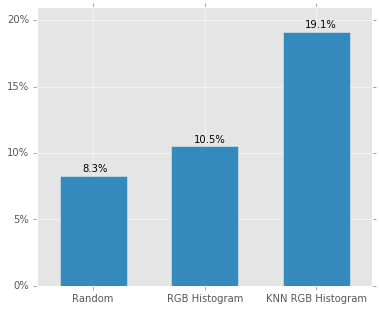

In [105]:
fig, ax = plt.subplots(figsize=(6,5))

ax.bar(positions, values, width=0.6, align='center')
ax.set_xticks(positions)
ax.set_xticklabels(labels)
ax.set_ylim(0, 0.21)
ax.set_yticklabels(["{:.0f}%".format(i*100) for i in ax.get_yticks()])
for x, y in zip(positions, values):
    ax.text(x-0.1, y + 0.003, "{:.1f}%".format(y*100))
plt.show()